# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [8]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [22]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [26]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


[autoreload of cs231n.classifiers.fc_net failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/benjaminshih/Desktop/assignment2/c

# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [27]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [28]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [29]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [30]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [37]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.12e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [44]:
model = TwoLayerNet()
solver = None
best_val = -1

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# Generate random hyperparameters given ranges for each of them
def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden

for i in range(20):
    lr, reg, hidden_size = generate_random_hyperparams(-4,-2, -7, -4, 10, 200)
    model = TwoLayerNet(hidden_dim = hidden_size, reg= reg)
    cur_solver = Solver(model, data, update_rule='sgd', optim_config={'learning_rate':lr}, 
                        lr_decay=0.95, num_epochs=5,batch_size=200, print_every=-1, verbose=False)
    cur_solver.train()
    val_accuracy = cur_solver.best_val_acc
    if best_val < val_accuracy:
        best_val = val_accuracy
        solver = cur_solver
    # Print results
    print('lr %e reg %e hid %d  val accuracy: %f' % (
                lr, reg, hidden_size, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

lr 6.671841e-04 reg 2.224537e-07 hid 175  val accuracy: 0.500000
lr 1.723987e-03 reg 6.326767e-07 hid 82  val accuracy: 0.494000
lr 8.287916e-03 reg 8.013736e-07 hid 169  val accuracy: 0.195000
lr 1.010691e-04 reg 6.977453e-07 hid 182  val accuracy: 0.391000
lr 3.394165e-04 reg 5.787047e-07 hid 196  val accuracy: 0.463000
lr 4.041163e-04 reg 1.421142e-05 hid 145  val accuracy: 0.471000
lr 1.376696e-04 reg 1.948542e-06 hid 143  val accuracy: 0.418000
lr 3.073032e-04 reg 1.201421e-05 hid 10  val accuracy: 0.343000
lr 4.000706e-03 reg 1.013580e-06 hid 34  val accuracy: 0.414000
lr 1.233506e-03 reg 6.663898e-06 hid 76  val accuracy: 0.487000
lr 3.779709e-03 reg 7.721784e-06 hid 49  val accuracy: 0.417000
lr 2.219750e-03 reg 4.342685e-05 hid 33  val accuracy: 0.472000
lr 3.441152e-03 reg 6.849724e-07 hid 43  val accuracy: 0.466000
lr 1.136023e-03 reg 2.958757e-06 hid 74  val accuracy: 0.476000
lr 3.377235e-04 reg 1.172716e-05 hid 53  val accuracy: 0.467000
lr 5.259303e-04 reg 7.502602e-06 h

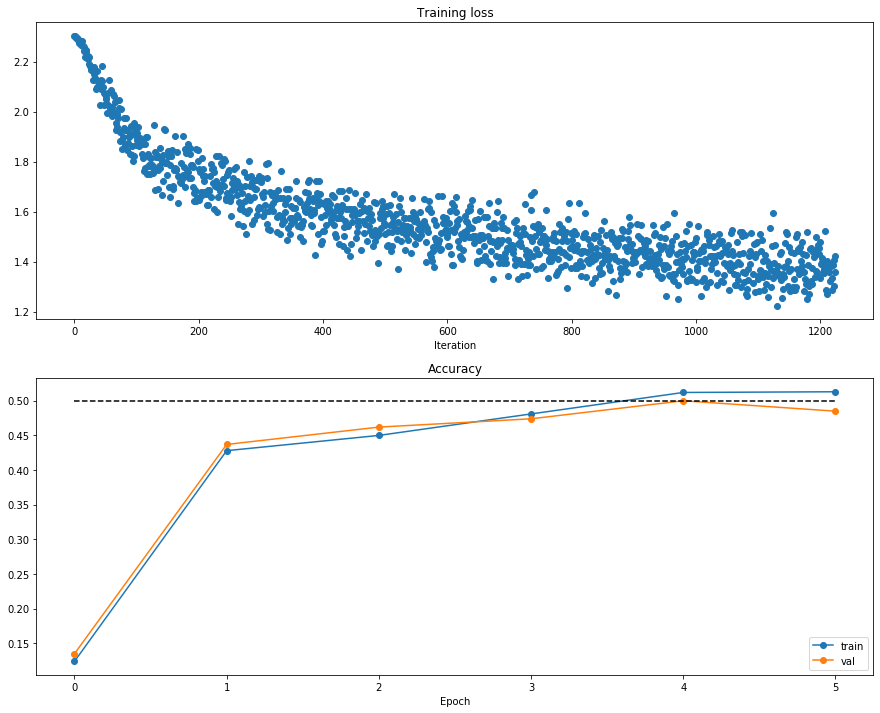

In [45]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [126]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))


Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.90e-09
W2 relative error: 6.87e-08
W3 relative error: 2.13e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.57e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

1000
(Iteration 1 / 40) loss: 2.363364
1000
(Epoch 0 / 20) train acc: 0.020000; val_acc: 0.105000
1000
(Epoch 1 / 20) train acc: 0.020000; val_acc: 0.106000
1000
(Epoch 2 / 20) train acc: 0.020000; val_acc: 0.110000
1000
(Epoch 3 / 20) train acc: 0.020000; val_acc: 0.110000
1000
(Epoch 4 / 20) train acc: 0.040000; val_acc: 0.109000
1000
(Epoch 5 / 20) train acc: 0.040000; val_acc: 0.111000
(Iteration 11 / 40) loss: 2.270022
1000
(Epoch 6 / 20) train acc: 0.040000; val_acc: 0.111000
1000
(Epoch 7 / 20) train acc: 0.060000; val_acc: 0.112000
1000
(Epoch 8 / 20) train acc: 0.060000; val_acc: 0.111000
1000
(Epoch 9 / 20) train acc: 0.040000; val_acc: 0.110000
1000
(Epoch 10 / 20) train acc: 0.040000; val_acc: 0.109000
(Iteration 21 / 40) loss: 2.309562
1000
(Epoch 11 / 20) train acc: 0.060000; val_acc: 0.110000
1000
(Epoch 12 / 20) train acc: 0.060000; val_acc: 0.110000
1000
(Epoch 13 / 20) train acc: 0.060000; val_acc: 0.110000
1000
(Epoch 14 / 20) train acc: 0.060000; val_acc: 0.110000
1

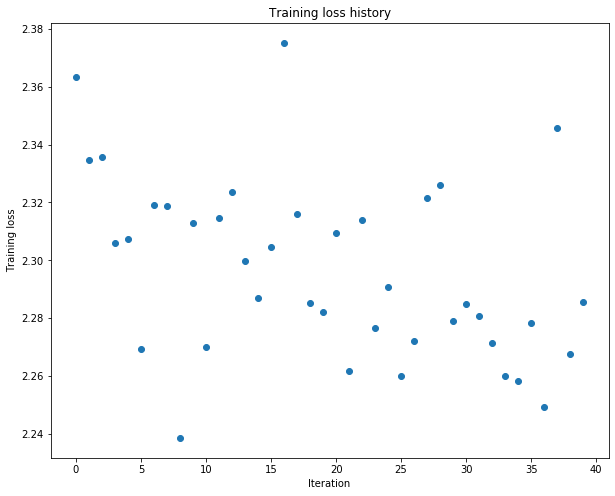

In [127]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-4
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd', num_train_samples = 1000,
                optim_config={
                  'learning_rate': learning_rate,
                },
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()


Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

1000
(Iteration 1 / 40) loss: 2.302585
1000
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
1000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
1000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
1000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
1000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
1000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.302273
1000
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
1000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
1000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
1000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
1000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.302221
1000
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
1000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
1000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
1000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
1

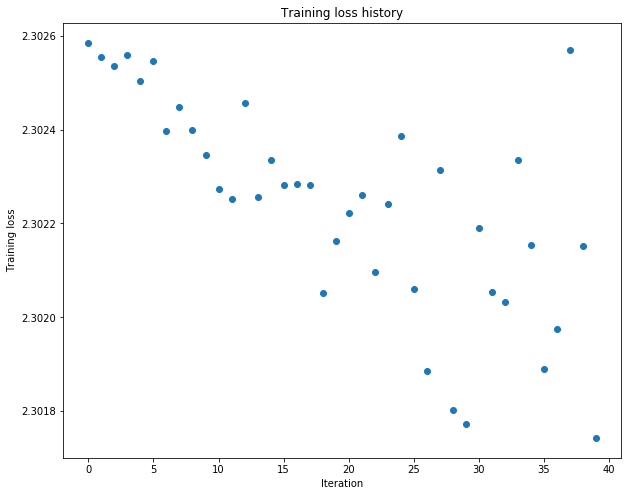

In [128]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-3
weight_scale = 1e-5
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
[FILL THIS IN]


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [129]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
1000
(Iteration 1 / 200) loss: 2.559978
1000
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.108000
(Iteration 11 / 200) loss: 2.291087
(Iteration 21 / 200) loss: 2.153591
(Iteration 31 / 200) loss: 2.082693
1000
(Epoch 1 / 5) train acc: 0.277000; val_acc: 0.242000
(Iteration 41 / 200) loss: 2.004171
(Iteration 51 / 200) loss: 2.010409
(Iteration 61 / 200) loss: 2.023753
(Iteration 71 / 200) loss: 2.026621
1000
(Epoch 2 / 5) train acc: 0.352000; val_acc: 0.312000
(Iteration 81 / 200) loss: 1.807164
(Iteration 91 / 200) loss: 1.915726
(Iteration 101 / 200) loss: 1.921844
(Iteration 111 / 200) loss: 1.708426
1000
(Epoch 3 / 5) train acc: 0.399000; val_acc: 0.318000
(Iteration 121 / 200) loss: 1.699806
(Iteration 131 / 200) loss: 1.771857
(Iteration 141 / 200) loss: 1.790065
(Iteration 151 / 200) loss: 1.820861
1000
(Epoch 4 / 5) train acc: 0.430000; val_acc: 0.324000
(Iteration 161 / 200) loss: 1.627657
(Iteration 171 / 200) loss: 1.899449
(Iteration 181 / 200) loss: 1.55

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

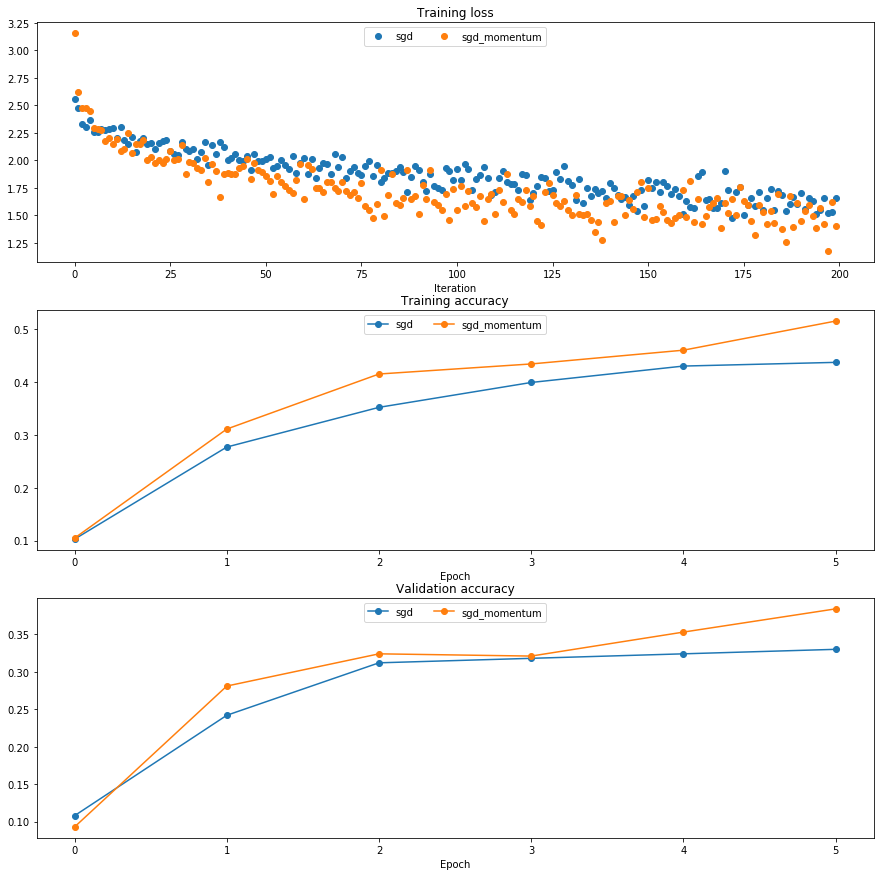

In [130]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [131]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [132]:
# Test Adam implementation; you should see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  0.20720703668629928
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
1000
(Iteration 1 / 200) loss: 3.476928
1000
(Epoch 0 / 5) train acc: 0.105000; val_acc: 0.100000
(Iteration 11 / 200) loss: 2.036672
(Iteration 21 / 200) loss: 2.231718
(Iteration 31 / 200) loss: 1.986361
1000
(Epoch 1 / 5) train acc: 0.290000; val_acc: 0.234000
(Iteration 41 / 200) loss: 1.965297
(Iteration 51 / 200) loss: 1.855777
(Iteration 61 / 200) loss: 1.982427
(Iteration 71 / 200) loss: 1.698222
1000
(Epoch 2 / 5) train acc: 0.324000; val_acc: 0.293000
(Iteration 81 / 200) loss: 1.729007
(Iteration 91 / 200) loss: 1.618394
(Iteration 101 / 200) loss: 1.645656
(Iteration 111 / 200) loss: 1.918085
1000
(Epoch 3 / 5) train acc: 0.343000; val_acc: 0.298000
(Iteration 121 / 200) loss: 1.621964
(Iteration 131 / 200) loss: 1.794089
(Iteration 141 / 200) loss: 1.722247
(Iteration 151 / 200) loss: 1.682374
1000
(Epoch 4 / 5) train acc: 0.426000; val_acc: 0.352000
(Iteration 161 / 200) loss: 1.837744
(Iteration 171 / 200) loss: 1.421418
(Iteration 181 / 200) loss: 1.5

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

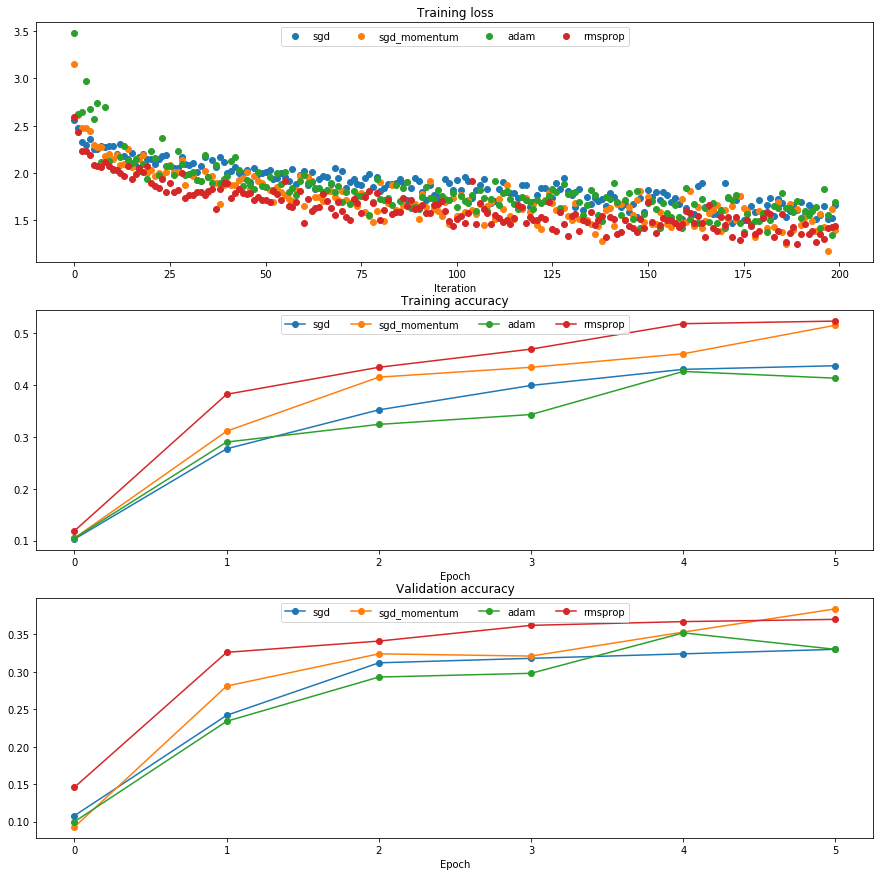

In [133]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [134]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
for i in range(25):
    lr = 10**np.random.uniform(-5, -1)
    ws = 10**np.random.uniform(-3, -1)
    reg = 10**np.random.uniform(-3, 3)
    
    model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=ws, reg = reg)
    solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': lr,
                }
         )
    solver.train()
    val_accuracy = solver.best_val_acc
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_model = model
    print('lr %e ws %e reg %e val accuracy: %f' % (
                lr, ws, reg, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

1000
(Iteration 1 / 3200) loss: 3.277046
1000
(Epoch 0 / 20) train acc: 0.105000; val_acc: 0.099000
(Iteration 11 / 3200) loss: 3.267011
(Iteration 21 / 3200) loss: 3.268618
(Iteration 31 / 3200) loss: 3.268784
(Iteration 41 / 3200) loss: 3.280413
(Iteration 51 / 3200) loss: 3.283963
(Iteration 61 / 3200) loss: 3.286433
(Iteration 71 / 3200) loss: 3.281158
(Iteration 81 / 3200) loss: 3.273258
(Iteration 91 / 3200) loss: 3.287976
(Iteration 101 / 3200) loss: 3.269454
(Iteration 111 / 3200) loss: 3.288426
(Iteration 121 / 3200) loss: 3.269850
(Iteration 131 / 3200) loss: 3.267228
(Iteration 141 / 3200) loss: 3.290492
(Iteration 151 / 3200) loss: 3.294788
1000
(Epoch 1 / 20) train acc: 0.110000; val_acc: 0.099000
(Iteration 161 / 3200) loss: 3.298286
(Iteration 171 / 3200) loss: 3.284665
(Iteration 181 / 3200) loss: 3.269868
(Iteration 191 / 3200) loss: 3.269598
(Iteration 201 / 3200) loss: 3.280029
(Iteration 211 / 3200) loss: 3.275354
(Iteration 221 / 3200) loss: 3.282960
(Iteration 231

(Iteration 1951 / 3200) loss: 3.287313
(Iteration 1961 / 3200) loss: 3.273990
(Iteration 1971 / 3200) loss: 3.287706
(Iteration 1981 / 3200) loss: 3.267796
(Iteration 1991 / 3200) loss: 3.282995
(Iteration 2001 / 3200) loss: 3.300614
(Iteration 2011 / 3200) loss: 3.280068
(Iteration 2021 / 3200) loss: 3.264571
(Iteration 2031 / 3200) loss: 3.274443
(Iteration 2041 / 3200) loss: 3.276127
(Iteration 2051 / 3200) loss: 3.281992
(Iteration 2061 / 3200) loss: 3.279849
(Iteration 2071 / 3200) loss: 3.303883
1000
(Epoch 13 / 20) train acc: 0.095000; val_acc: 0.103000
(Iteration 2081 / 3200) loss: 3.276591
(Iteration 2091 / 3200) loss: 3.274634
(Iteration 2101 / 3200) loss: 3.296346
(Iteration 2111 / 3200) loss: 3.280079
(Iteration 2121 / 3200) loss: 3.292484
(Iteration 2131 / 3200) loss: 3.275768
(Iteration 2141 / 3200) loss: 3.280153
(Iteration 2151 / 3200) loss: 3.270285
(Iteration 2161 / 3200) loss: 3.273728
(Iteration 2171 / 3200) loss: 3.274372
(Iteration 2181 / 3200) loss: 3.285618
(Ite

(Iteration 671 / 3200) loss: 2.757304
(Iteration 681 / 3200) loss: 2.755668
(Iteration 691 / 3200) loss: 2.752387
(Iteration 701 / 3200) loss: 2.750594
(Iteration 711 / 3200) loss: 2.747714
(Iteration 721 / 3200) loss: 2.743587
(Iteration 731 / 3200) loss: 2.741225
(Iteration 741 / 3200) loss: 2.738324
(Iteration 751 / 3200) loss: 2.735606
(Iteration 761 / 3200) loss: 2.732894
(Iteration 771 / 3200) loss: 2.729746
(Iteration 781 / 3200) loss: 2.727488
(Iteration 791 / 3200) loss: 2.724639
1000
(Epoch 5 / 20) train acc: 0.091000; val_acc: 0.079000
(Iteration 801 / 3200) loss: 2.723133
(Iteration 811 / 3200) loss: 2.721574
(Iteration 821 / 3200) loss: 2.717576
(Iteration 831 / 3200) loss: 2.716005
(Iteration 841 / 3200) loss: 2.711845
(Iteration 851 / 3200) loss: 2.709726
(Iteration 861 / 3200) loss: 2.707335
(Iteration 871 / 3200) loss: 2.707514
(Iteration 881 / 3200) loss: 2.703922
(Iteration 891 / 3200) loss: 2.700535
(Iteration 901 / 3200) loss: 2.698312
(Iteration 911 / 3200) loss: 

(Iteration 2651 / 3200) loss: 2.437624
(Iteration 2661 / 3200) loss: 2.437876
(Iteration 2671 / 3200) loss: 2.436924
(Iteration 2681 / 3200) loss: 2.438929
(Iteration 2691 / 3200) loss: 2.435627
(Iteration 2701 / 3200) loss: 2.437132
(Iteration 2711 / 3200) loss: 2.435549
1000
(Epoch 17 / 20) train acc: 0.117000; val_acc: 0.079000
(Iteration 2721 / 3200) loss: 2.436362
(Iteration 2731 / 3200) loss: 2.429762
(Iteration 2741 / 3200) loss: 2.429420
(Iteration 2751 / 3200) loss: 2.431381
(Iteration 2761 / 3200) loss: 2.430791
(Iteration 2771 / 3200) loss: 2.434197
(Iteration 2781 / 3200) loss: 2.432488
(Iteration 2791 / 3200) loss: 2.424445
(Iteration 2801 / 3200) loss: 2.428712
(Iteration 2811 / 3200) loss: 2.425244
(Iteration 2821 / 3200) loss: 2.427588
(Iteration 2831 / 3200) loss: 2.422565
(Iteration 2841 / 3200) loss: 2.422599
(Iteration 2851 / 3200) loss: 2.426870
(Iteration 2861 / 3200) loss: 2.419986
(Iteration 2871 / 3200) loss: 2.426894
1000
(Epoch 18 / 20) train acc: 0.090000; v

/Users/benjaminshih/Desktop/assignment2/cs231n/layers.py:558: RuntimeWarning: invalid value encountered in subtract
  shifted_logits = x - np.max(x, axis=1, keepdims=True)
/Users/benjaminshih/Desktop/assignment2/cs231n/layers.py:109: RuntimeWarning: invalid value encountered in greater
  dx = dout * (x>0)


(Iteration 31 / 3200) loss: nan
(Iteration 41 / 3200) loss: nan
(Iteration 51 / 3200) loss: nan
(Iteration 61 / 3200) loss: nan
(Iteration 71 / 3200) loss: nan
(Iteration 81 / 3200) loss: nan
(Iteration 91 / 3200) loss: nan
(Iteration 101 / 3200) loss: nan
(Iteration 111 / 3200) loss: nan
(Iteration 121 / 3200) loss: nan
(Iteration 131 / 3200) loss: nan
(Iteration 141 / 3200) loss: nan
(Iteration 151 / 3200) loss: nan
1000
(Epoch 1 / 20) train acc: 0.106000; val_acc: 0.087000
(Iteration 161 / 3200) loss: nan
(Iteration 171 / 3200) loss: nan
(Iteration 181 / 3200) loss: nan
(Iteration 191 / 3200) loss: nan
(Iteration 201 / 3200) loss: nan
(Iteration 211 / 3200) loss: nan
(Iteration 221 / 3200) loss: nan
(Iteration 231 / 3200) loss: nan
(Iteration 241 / 3200) loss: nan
(Iteration 251 / 3200) loss: nan
(Iteration 261 / 3200) loss: nan
(Iteration 271 / 3200) loss: nan
(Iteration 281 / 3200) loss: nan
(Iteration 291 / 3200) loss: nan
(Iteration 301 / 3200) loss: nan
(Iteration 311 / 3200) l

(Iteration 2271 / 3200) loss: nan
(Iteration 2281 / 3200) loss: nan
(Iteration 2291 / 3200) loss: nan
(Iteration 2301 / 3200) loss: nan
(Iteration 2311 / 3200) loss: nan
(Iteration 2321 / 3200) loss: nan
(Iteration 2331 / 3200) loss: nan
(Iteration 2341 / 3200) loss: nan
(Iteration 2351 / 3200) loss: nan
(Iteration 2361 / 3200) loss: nan
(Iteration 2371 / 3200) loss: nan
(Iteration 2381 / 3200) loss: nan
(Iteration 2391 / 3200) loss: nan
1000
(Epoch 15 / 20) train acc: 0.108000; val_acc: 0.087000
(Iteration 2401 / 3200) loss: nan
(Iteration 2411 / 3200) loss: nan
(Iteration 2421 / 3200) loss: nan
(Iteration 2431 / 3200) loss: nan
(Iteration 2441 / 3200) loss: nan
(Iteration 2451 / 3200) loss: nan
(Iteration 2461 / 3200) loss: nan
(Iteration 2471 / 3200) loss: nan
(Iteration 2481 / 3200) loss: nan
(Iteration 2491 / 3200) loss: nan
(Iteration 2501 / 3200) loss: nan
(Iteration 2511 / 3200) loss: nan
(Iteration 2521 / 3200) loss: nan
(Iteration 2531 / 3200) loss: nan
(Iteration 2541 / 3200

(Iteration 1101 / 3200) loss: 2.302598
(Iteration 1111 / 3200) loss: 2.302281
1000
(Epoch 7 / 20) train acc: 0.095000; val_acc: 0.102000
(Iteration 1121 / 3200) loss: 2.302653
(Iteration 1131 / 3200) loss: 2.302723
(Iteration 1141 / 3200) loss: 2.302225
(Iteration 1151 / 3200) loss: 2.302604
(Iteration 1161 / 3200) loss: 2.302316
(Iteration 1171 / 3200) loss: 2.302314
(Iteration 1181 / 3200) loss: 2.302309
(Iteration 1191 / 3200) loss: 2.302411
(Iteration 1201 / 3200) loss: 2.302702
(Iteration 1211 / 3200) loss: 2.302344
(Iteration 1221 / 3200) loss: 2.302675
(Iteration 1231 / 3200) loss: 2.302030
(Iteration 1241 / 3200) loss: 2.302353
(Iteration 1251 / 3200) loss: 2.301788
(Iteration 1261 / 3200) loss: 2.301835
(Iteration 1271 / 3200) loss: 2.302778
1000
(Epoch 8 / 20) train acc: 0.093000; val_acc: 0.078000
(Iteration 1281 / 3200) loss: 2.302003
(Iteration 1291 / 3200) loss: 2.302531
(Iteration 1301 / 3200) loss: 2.302622
(Iteration 1311 / 3200) loss: 2.302793
(Iteration 1321 / 3200) 

(Iteration 3021 / 3200) loss: 2.302978
(Iteration 3031 / 3200) loss: 2.302080
1000
(Epoch 19 / 20) train acc: 0.119000; val_acc: 0.078000
(Iteration 3041 / 3200) loss: 2.302408
(Iteration 3051 / 3200) loss: 2.301963
(Iteration 3061 / 3200) loss: 2.302033
(Iteration 3071 / 3200) loss: 2.303384
(Iteration 3081 / 3200) loss: 2.304381
(Iteration 3091 / 3200) loss: 2.301911
(Iteration 3101 / 3200) loss: 2.303206
(Iteration 3111 / 3200) loss: 2.301934
(Iteration 3121 / 3200) loss: 2.302916
(Iteration 3131 / 3200) loss: 2.302877
(Iteration 3141 / 3200) loss: 2.303333
(Iteration 3151 / 3200) loss: 2.302005
(Iteration 3161 / 3200) loss: 2.302803
(Iteration 3171 / 3200) loss: 2.302607
(Iteration 3181 / 3200) loss: 2.301479
(Iteration 3191 / 3200) loss: 2.302888
1000
(Epoch 20 / 20) train acc: 0.111000; val_acc: 0.078000
lr 3.144668e-04 ws 3.275645e-02 reg 3.255006e+02 val accuracy: 0.105000
1000
(Iteration 1 / 3200) loss: 2.787309
1000
(Epoch 0 / 20) train acc: 0.092000; val_acc: 0.092000
(Itera

(Iteration 1771 / 3200) loss: 2.775303
(Iteration 1781 / 3200) loss: 2.789679
(Iteration 1791 / 3200) loss: 2.765700
(Iteration 1801 / 3200) loss: 2.792538
(Iteration 1811 / 3200) loss: 2.794828
(Iteration 1821 / 3200) loss: 2.772682
(Iteration 1831 / 3200) loss: 2.782864
(Iteration 1841 / 3200) loss: 2.776289
(Iteration 1851 / 3200) loss: 2.794102
(Iteration 1861 / 3200) loss: 2.786974
(Iteration 1871 / 3200) loss: 2.785498
(Iteration 1881 / 3200) loss: 2.765570
(Iteration 1891 / 3200) loss: 2.768754
(Iteration 1901 / 3200) loss: 2.799408
(Iteration 1911 / 3200) loss: 2.774363
1000
(Epoch 12 / 20) train acc: 0.107000; val_acc: 0.101000
(Iteration 1921 / 3200) loss: 2.783337
(Iteration 1931 / 3200) loss: 2.769886
(Iteration 1941 / 3200) loss: 2.781543
(Iteration 1951 / 3200) loss: 2.807622
(Iteration 1961 / 3200) loss: 2.769290
(Iteration 1971 / 3200) loss: 2.778907
(Iteration 1981 / 3200) loss: 2.763847
(Iteration 1991 / 3200) loss: 2.794980
(Iteration 2001 / 3200) loss: 2.781287
(Ite

(Iteration 511 / 3200) loss: 2.307873
(Iteration 521 / 3200) loss: 2.307945
(Iteration 531 / 3200) loss: 2.308500
(Iteration 541 / 3200) loss: 2.306691
(Iteration 551 / 3200) loss: 2.307764
(Iteration 561 / 3200) loss: 2.308783
(Iteration 571 / 3200) loss: 2.310583
(Iteration 581 / 3200) loss: 2.312680
(Iteration 591 / 3200) loss: 2.309451
(Iteration 601 / 3200) loss: 2.310455
(Iteration 611 / 3200) loss: 2.305754
(Iteration 621 / 3200) loss: 2.309421
(Iteration 631 / 3200) loss: 2.306046
1000
(Epoch 4 / 20) train acc: 0.110000; val_acc: 0.078000
(Iteration 641 / 3200) loss: 2.307158
(Iteration 651 / 3200) loss: 2.306487
(Iteration 661 / 3200) loss: 2.308171
(Iteration 671 / 3200) loss: 2.309327
(Iteration 681 / 3200) loss: 2.305913
(Iteration 691 / 3200) loss: 2.309609
(Iteration 701 / 3200) loss: 2.304467
(Iteration 711 / 3200) loss: 2.305689
(Iteration 721 / 3200) loss: 2.303930
(Iteration 731 / 3200) loss: 2.302846
(Iteration 741 / 3200) loss: 2.305888
(Iteration 751 / 3200) loss: 

(Iteration 2471 / 3200) loss: 2.305818
(Iteration 2481 / 3200) loss: 2.313882
(Iteration 2491 / 3200) loss: 2.294591
(Iteration 2501 / 3200) loss: 2.312262
(Iteration 2511 / 3200) loss: 2.307523
(Iteration 2521 / 3200) loss: 2.295350
(Iteration 2531 / 3200) loss: 2.298995
(Iteration 2541 / 3200) loss: 2.309247
(Iteration 2551 / 3200) loss: 2.303761
1000
(Epoch 16 / 20) train acc: 0.117000; val_acc: 0.078000
(Iteration 2561 / 3200) loss: 2.314912
(Iteration 2571 / 3200) loss: 2.310247
(Iteration 2581 / 3200) loss: 2.303757
(Iteration 2591 / 3200) loss: 2.305127
(Iteration 2601 / 3200) loss: 2.292653
(Iteration 2611 / 3200) loss: 2.314933
(Iteration 2621 / 3200) loss: 2.312096
(Iteration 2631 / 3200) loss: 2.306106
(Iteration 2641 / 3200) loss: 2.305838
(Iteration 2651 / 3200) loss: 2.317078
(Iteration 2661 / 3200) loss: 2.318293
(Iteration 2671 / 3200) loss: 2.310630
(Iteration 2681 / 3200) loss: 2.298218
(Iteration 2691 / 3200) loss: 2.313738
(Iteration 2701 / 3200) loss: 2.312429
(Ite

(Iteration 1191 / 3200) loss: 2.312075
(Iteration 1201 / 3200) loss: 2.304188
(Iteration 1211 / 3200) loss: 2.310769
(Iteration 1221 / 3200) loss: 2.313058
(Iteration 1231 / 3200) loss: 2.329829
(Iteration 1241 / 3200) loss: 2.310893
(Iteration 1251 / 3200) loss: 2.308844
(Iteration 1261 / 3200) loss: 2.310897
(Iteration 1271 / 3200) loss: 2.336782
1000
(Epoch 8 / 20) train acc: 0.112000; val_acc: 0.079000
(Iteration 1281 / 3200) loss: 2.288577
(Iteration 1291 / 3200) loss: 2.319642
(Iteration 1301 / 3200) loss: 2.314896
(Iteration 1311 / 3200) loss: 2.299380
(Iteration 1321 / 3200) loss: 2.308369
(Iteration 1331 / 3200) loss: 2.302319
(Iteration 1341 / 3200) loss: 2.320834
(Iteration 1351 / 3200) loss: 2.302775
(Iteration 1361 / 3200) loss: 2.301212
(Iteration 1371 / 3200) loss: 2.300390
(Iteration 1381 / 3200) loss: 2.305177
(Iteration 1391 / 3200) loss: 2.309609
(Iteration 1401 / 3200) loss: 2.311153
(Iteration 1411 / 3200) loss: 2.297344
(Iteration 1421 / 3200) loss: 2.304562
(Iter

(Iteration 3131 / 3200) loss: 2.298638
(Iteration 3141 / 3200) loss: 2.292971
(Iteration 3151 / 3200) loss: 2.291749
(Iteration 3161 / 3200) loss: 2.295630
(Iteration 3171 / 3200) loss: 2.316113
(Iteration 3181 / 3200) loss: 2.299822
(Iteration 3191 / 3200) loss: 2.306773
1000
(Epoch 20 / 20) train acc: 0.110000; val_acc: 0.079000
lr 3.474146e-02 ws 4.090187e-03 reg 1.597763e-02 val accuracy: 0.119000
1000
(Iteration 1 / 3200) loss: 5132.616990
1000
(Epoch 0 / 20) train acc: 0.123000; val_acc: 0.105000
(Iteration 11 / 3200) loss: 4600.545821
(Iteration 21 / 3200) loss: 4163.920167
(Iteration 31 / 3200) loss: 3772.925311
(Iteration 41 / 3200) loss: 3421.961347
(Iteration 51 / 3200) loss: 3104.000965
(Iteration 61 / 3200) loss: 2815.134851
(Iteration 71 / 3200) loss: 2554.070712
(Iteration 81 / 3200) loss: 2317.026660
(Iteration 91 / 3200) loss: 2101.921882
(Iteration 101 / 3200) loss: 1907.165692
(Iteration 111 / 3200) loss: 1730.161093
(Iteration 121 / 3200) loss: 1569.760885
(Iteratio

(Iteration 1841 / 3200) loss: 2.302625
(Iteration 1851 / 3200) loss: 2.299949
(Iteration 1861 / 3200) loss: 2.300815
(Iteration 1871 / 3200) loss: 2.299962
(Iteration 1881 / 3200) loss: 2.300225
(Iteration 1891 / 3200) loss: 2.300312
(Iteration 1901 / 3200) loss: 2.304617
(Iteration 1911 / 3200) loss: 2.303094
1000
(Epoch 12 / 20) train acc: 0.094000; val_acc: 0.078000
(Iteration 1921 / 3200) loss: 2.302889
(Iteration 1931 / 3200) loss: 2.305607
(Iteration 1941 / 3200) loss: 2.303703
(Iteration 1951 / 3200) loss: 2.302331
(Iteration 1961 / 3200) loss: 2.298431
(Iteration 1971 / 3200) loss: 2.301955
(Iteration 1981 / 3200) loss: 2.305165
(Iteration 1991 / 3200) loss: 2.305669
(Iteration 2001 / 3200) loss: 2.300685
(Iteration 2011 / 3200) loss: 2.304864
(Iteration 2021 / 3200) loss: 2.304940
(Iteration 2031 / 3200) loss: 2.298290
(Iteration 2041 / 3200) loss: 2.299373
(Iteration 2051 / 3200) loss: 2.306104
(Iteration 2061 / 3200) loss: 2.304756
(Iteration 2071 / 3200) loss: 2.308380
1000

(Iteration 631 / 3200) loss: nan
1000
(Epoch 4 / 20) train acc: 0.106000; val_acc: 0.087000
(Iteration 641 / 3200) loss: nan
(Iteration 651 / 3200) loss: nan
(Iteration 661 / 3200) loss: nan
(Iteration 671 / 3200) loss: nan
(Iteration 681 / 3200) loss: nan
(Iteration 691 / 3200) loss: nan
(Iteration 701 / 3200) loss: nan
(Iteration 711 / 3200) loss: nan
(Iteration 721 / 3200) loss: nan
(Iteration 731 / 3200) loss: nan
(Iteration 741 / 3200) loss: nan
(Iteration 751 / 3200) loss: nan
(Iteration 761 / 3200) loss: nan
(Iteration 771 / 3200) loss: nan
(Iteration 781 / 3200) loss: nan
(Iteration 791 / 3200) loss: nan
1000
(Epoch 5 / 20) train acc: 0.096000; val_acc: 0.087000
(Iteration 801 / 3200) loss: nan
(Iteration 811 / 3200) loss: nan
(Iteration 821 / 3200) loss: nan
(Iteration 831 / 3200) loss: nan
(Iteration 841 / 3200) loss: nan
(Iteration 851 / 3200) loss: nan
(Iteration 861 / 3200) loss: nan
(Iteration 871 / 3200) loss: nan
(Iteration 881 / 3200) loss: nan
(Iteration 891 / 3200) l

(Iteration 2841 / 3200) loss: nan
(Iteration 2851 / 3200) loss: nan
(Iteration 2861 / 3200) loss: nan
(Iteration 2871 / 3200) loss: nan
1000
(Epoch 18 / 20) train acc: 0.100000; val_acc: 0.087000
(Iteration 2881 / 3200) loss: nan
(Iteration 2891 / 3200) loss: nan
(Iteration 2901 / 3200) loss: nan
(Iteration 2911 / 3200) loss: nan
(Iteration 2921 / 3200) loss: nan
(Iteration 2931 / 3200) loss: nan
(Iteration 2941 / 3200) loss: nan
(Iteration 2951 / 3200) loss: nan
(Iteration 2961 / 3200) loss: nan
(Iteration 2971 / 3200) loss: nan
(Iteration 2981 / 3200) loss: nan
(Iteration 2991 / 3200) loss: nan
(Iteration 3001 / 3200) loss: nan
(Iteration 3011 / 3200) loss: nan
(Iteration 3021 / 3200) loss: nan
(Iteration 3031 / 3200) loss: nan
1000
(Epoch 19 / 20) train acc: 0.104000; val_acc: 0.087000
(Iteration 3041 / 3200) loss: nan
(Iteration 3051 / 3200) loss: nan
(Iteration 3061 / 3200) loss: nan
(Iteration 3071 / 3200) loss: nan
(Iteration 3081 / 3200) loss: nan
(Iteration 3091 / 3200) loss: 

(Iteration 1621 / 3200) loss: 2.319666
(Iteration 1631 / 3200) loss: 2.319959
(Iteration 1641 / 3200) loss: 2.319827
(Iteration 1651 / 3200) loss: 2.320051
(Iteration 1661 / 3200) loss: 2.319836
(Iteration 1671 / 3200) loss: 2.319760
(Iteration 1681 / 3200) loss: 2.319986
(Iteration 1691 / 3200) loss: 2.319691
(Iteration 1701 / 3200) loss: 2.319533
(Iteration 1711 / 3200) loss: 2.319740
(Iteration 1721 / 3200) loss: 2.319866
(Iteration 1731 / 3200) loss: 2.319696
(Iteration 1741 / 3200) loss: 2.319710
(Iteration 1751 / 3200) loss: 2.319694
1000
(Epoch 11 / 20) train acc: 0.132000; val_acc: 0.096000
(Iteration 1761 / 3200) loss: 2.319840
(Iteration 1771 / 3200) loss: 2.319811
(Iteration 1781 / 3200) loss: 2.319641
(Iteration 1791 / 3200) loss: 2.319852
(Iteration 1801 / 3200) loss: 2.319799
(Iteration 1811 / 3200) loss: 2.319702
(Iteration 1821 / 3200) loss: 2.319849
(Iteration 1831 / 3200) loss: 2.319742
(Iteration 1841 / 3200) loss: 2.319879
(Iteration 1851 / 3200) loss: 2.319738
(Ite

(Iteration 401 / 3200) loss: 6.447852
(Iteration 411 / 3200) loss: 6.553340
(Iteration 421 / 3200) loss: 6.459770
(Iteration 431 / 3200) loss: 6.384744
(Iteration 441 / 3200) loss: 6.422844
(Iteration 451 / 3200) loss: 6.548297
(Iteration 461 / 3200) loss: 6.275944
(Iteration 471 / 3200) loss: 6.619562
1000
(Epoch 3 / 20) train acc: 0.330000; val_acc: 0.331000
(Iteration 481 / 3200) loss: 6.460634
(Iteration 491 / 3200) loss: 6.282967
(Iteration 501 / 3200) loss: 6.481849
(Iteration 511 / 3200) loss: 6.145724
(Iteration 521 / 3200) loss: 6.109116
(Iteration 531 / 3200) loss: 6.336701
(Iteration 541 / 3200) loss: 6.350995
(Iteration 551 / 3200) loss: 6.330056
(Iteration 561 / 3200) loss: 6.361114
(Iteration 571 / 3200) loss: 6.238063
(Iteration 581 / 3200) loss: 6.290575
(Iteration 591 / 3200) loss: 6.436937
(Iteration 601 / 3200) loss: 6.190568
(Iteration 611 / 3200) loss: 6.222475
(Iteration 621 / 3200) loss: 6.063187
(Iteration 631 / 3200) loss: 6.290628
1000
(Epoch 4 / 20) train acc

(Iteration 2341 / 3200) loss: 4.588672
(Iteration 2351 / 3200) loss: 4.535006
(Iteration 2361 / 3200) loss: 4.577363
(Iteration 2371 / 3200) loss: 4.672008
(Iteration 2381 / 3200) loss: 4.635591
(Iteration 2391 / 3200) loss: 4.689054
1000
(Epoch 15 / 20) train acc: 0.625000; val_acc: 0.415000
(Iteration 2401 / 3200) loss: 4.462682
(Iteration 2411 / 3200) loss: 4.458016
(Iteration 2421 / 3200) loss: 4.683895
(Iteration 2431 / 3200) loss: 4.623858
(Iteration 2441 / 3200) loss: 4.562759
(Iteration 2451 / 3200) loss: 4.474038
(Iteration 2461 / 3200) loss: 5.004317
(Iteration 2471 / 3200) loss: 4.899919
(Iteration 2481 / 3200) loss: 4.363983
(Iteration 2491 / 3200) loss: 4.398231
(Iteration 2501 / 3200) loss: 4.962135
(Iteration 2511 / 3200) loss: 5.017669
(Iteration 2521 / 3200) loss: 4.538103
(Iteration 2531 / 3200) loss: 4.390334
(Iteration 2541 / 3200) loss: 4.394296
(Iteration 2551 / 3200) loss: 4.592574
1000
(Epoch 16 / 20) train acc: 0.595000; val_acc: 0.388000
(Iteration 2561 / 3200

(Iteration 1081 / 3200) loss: 2.304477
(Iteration 1091 / 3200) loss: 2.304499
(Iteration 1101 / 3200) loss: 2.304468
(Iteration 1111 / 3200) loss: 2.304471
1000
(Epoch 7 / 20) train acc: 0.094000; val_acc: 0.105000
(Iteration 1121 / 3200) loss: 2.304480
(Iteration 1131 / 3200) loss: 2.304488
(Iteration 1141 / 3200) loss: 2.304494
(Iteration 1151 / 3200) loss: 2.304518
(Iteration 1161 / 3200) loss: 2.304486
(Iteration 1171 / 3200) loss: 2.304474
(Iteration 1181 / 3200) loss: 2.304466
(Iteration 1191 / 3200) loss: 2.304497
(Iteration 1201 / 3200) loss: 2.304466
(Iteration 1211 / 3200) loss: 2.304535
(Iteration 1221 / 3200) loss: 2.304449
(Iteration 1231 / 3200) loss: 2.304477
(Iteration 1241 / 3200) loss: 2.304492
(Iteration 1251 / 3200) loss: 2.304482
(Iteration 1261 / 3200) loss: 2.304519
(Iteration 1271 / 3200) loss: 2.304469
1000
(Epoch 8 / 20) train acc: 0.100000; val_acc: 0.105000
(Iteration 1281 / 3200) loss: 2.304439
(Iteration 1291 / 3200) loss: 2.304516
(Iteration 1301 / 3200) 

(Iteration 3061 / 3200) loss: 2.304532
(Iteration 3071 / 3200) loss: 2.304486
(Iteration 3081 / 3200) loss: 2.304525
(Iteration 3091 / 3200) loss: 2.304455
(Iteration 3101 / 3200) loss: 2.304432
(Iteration 3111 / 3200) loss: 2.304504
(Iteration 3121 / 3200) loss: 2.304552
(Iteration 3131 / 3200) loss: 2.304450
(Iteration 3141 / 3200) loss: 2.304409
(Iteration 3151 / 3200) loss: 2.304544
(Iteration 3161 / 3200) loss: 2.304462
(Iteration 3171 / 3200) loss: 2.304413
(Iteration 3181 / 3200) loss: 2.304410
(Iteration 3191 / 3200) loss: 2.304500
1000
(Epoch 20 / 20) train acc: 0.099000; val_acc: 0.079000
lr 2.515291e-05 ws 1.680120e-03 reg 3.969820e-03 val accuracy: 0.112000
1000
(Iteration 1 / 3200) loss: 2093.645517
1000
(Epoch 0 / 20) train acc: 0.142000; val_acc: 0.119000
(Iteration 11 / 3200) loss: 237.450073
(Iteration 21 / 3200) loss: 28.742202
(Iteration 31 / 3200) loss: 5.275479
(Iteration 41 / 3200) loss: 2.636863
(Iteration 51 / 3200) loss: 2.340313
(Iteration 61 / 3200) loss: 2.3

(Iteration 1781 / 3200) loss: 2.302525
(Iteration 1791 / 3200) loss: 2.301301
(Iteration 1801 / 3200) loss: 2.302362
(Iteration 1811 / 3200) loss: 2.302494
(Iteration 1821 / 3200) loss: 2.302924
(Iteration 1831 / 3200) loss: 2.304168
(Iteration 1841 / 3200) loss: 2.303283
(Iteration 1851 / 3200) loss: 2.303076
(Iteration 1861 / 3200) loss: 2.302403
(Iteration 1871 / 3200) loss: 2.302432
(Iteration 1881 / 3200) loss: 2.302342
(Iteration 1891 / 3200) loss: 2.301867
(Iteration 1901 / 3200) loss: 2.303255
(Iteration 1911 / 3200) loss: 2.300435
1000
(Epoch 12 / 20) train acc: 0.107000; val_acc: 0.079000
(Iteration 1921 / 3200) loss: 2.301068
(Iteration 1931 / 3200) loss: 2.302124
(Iteration 1941 / 3200) loss: 2.301372
(Iteration 1951 / 3200) loss: 2.302634
(Iteration 1961 / 3200) loss: 2.302533
(Iteration 1971 / 3200) loss: 2.302810
(Iteration 1981 / 3200) loss: 2.301553
(Iteration 1991 / 3200) loss: 2.303001
(Iteration 2001 / 3200) loss: 2.301880
(Iteration 2011 / 3200) loss: 2.300807
(Ite

(Iteration 541 / 3200) loss: 2.312662
(Iteration 551 / 3200) loss: 2.310934
(Iteration 561 / 3200) loss: 2.314471
(Iteration 571 / 3200) loss: 2.317740
(Iteration 581 / 3200) loss: 2.307479
(Iteration 591 / 3200) loss: 2.308248
(Iteration 601 / 3200) loss: 2.313618
(Iteration 611 / 3200) loss: 2.311330
(Iteration 621 / 3200) loss: 2.316304
(Iteration 631 / 3200) loss: 2.317255
1000
(Epoch 4 / 20) train acc: 0.104000; val_acc: 0.079000
(Iteration 641 / 3200) loss: 2.315444
(Iteration 651 / 3200) loss: 2.301662
(Iteration 661 / 3200) loss: 2.311903
(Iteration 671 / 3200) loss: 2.324412
(Iteration 681 / 3200) loss: 2.310175
(Iteration 691 / 3200) loss: 2.297107
(Iteration 701 / 3200) loss: 2.317748
(Iteration 711 / 3200) loss: 2.307487
(Iteration 721 / 3200) loss: 2.311202
(Iteration 731 / 3200) loss: 2.310516
(Iteration 741 / 3200) loss: 2.307283
(Iteration 751 / 3200) loss: 2.298964
(Iteration 761 / 3200) loss: 2.306872
(Iteration 771 / 3200) loss: 2.310993
(Iteration 781 / 3200) loss: 

(Iteration 2521 / 3200) loss: 1.422590
(Iteration 2531 / 3200) loss: 1.724851
(Iteration 2541 / 3200) loss: 1.858628
(Iteration 2551 / 3200) loss: 1.699529
1000
(Epoch 16 / 20) train acc: 0.360000; val_acc: 0.288000
(Iteration 2561 / 3200) loss: 1.383465
(Iteration 2571 / 3200) loss: 1.441345
(Iteration 2581 / 3200) loss: 1.736408
(Iteration 2591 / 3200) loss: 1.538649
(Iteration 2601 / 3200) loss: 1.952752
(Iteration 2611 / 3200) loss: 2.026900
(Iteration 2621 / 3200) loss: 1.651450
(Iteration 2631 / 3200) loss: 1.518093
(Iteration 2641 / 3200) loss: 1.524456
(Iteration 2651 / 3200) loss: 1.834577
(Iteration 2661 / 3200) loss: 1.780235
(Iteration 2671 / 3200) loss: 1.752907
(Iteration 2681 / 3200) loss: 1.539979
(Iteration 2691 / 3200) loss: 1.422445
(Iteration 2701 / 3200) loss: 1.273688
(Iteration 2711 / 3200) loss: 1.360551
1000
(Epoch 17 / 20) train acc: 0.396000; val_acc: 0.291000
(Iteration 2721 / 3200) loss: 1.655027
(Iteration 2731 / 3200) loss: 1.616964
(Iteration 2741 / 3200

(Iteration 1251 / 3200) loss: 2.310506
(Iteration 1261 / 3200) loss: 2.312372
(Iteration 1271 / 3200) loss: 2.312927
1000
(Epoch 8 / 20) train acc: 0.094000; val_acc: 0.079000
(Iteration 1281 / 3200) loss: 2.314863
(Iteration 1291 / 3200) loss: 2.310063
(Iteration 1301 / 3200) loss: 2.310487
(Iteration 1311 / 3200) loss: 2.312454
(Iteration 1321 / 3200) loss: 2.313225
(Iteration 1331 / 3200) loss: 2.310985
(Iteration 1341 / 3200) loss: 2.306203
(Iteration 1351 / 3200) loss: 2.309858
(Iteration 1361 / 3200) loss: 2.312446
(Iteration 1371 / 3200) loss: 2.312404
(Iteration 1381 / 3200) loss: 2.312219
(Iteration 1391 / 3200) loss: 2.309290
(Iteration 1401 / 3200) loss: 2.308561
(Iteration 1411 / 3200) loss: 2.316020
(Iteration 1421 / 3200) loss: 2.312615
(Iteration 1431 / 3200) loss: 2.311936
1000
(Epoch 9 / 20) train acc: 0.098000; val_acc: 0.079000
(Iteration 1441 / 3200) loss: 2.313942
(Iteration 1451 / 3200) loss: 2.307920
(Iteration 1461 / 3200) loss: 2.312488
(Iteration 1471 / 3200) 

(Iteration 3191 / 3200) loss: 2.306551
1000
(Epoch 20 / 20) train acc: 0.118000; val_acc: 0.079000
lr 1.952024e-03 ws 1.024014e-03 reg 6.662639e-02 val accuracy: 0.105000
1000
(Iteration 1 / 3200) loss: 2.548439
1000
(Epoch 0 / 20) train acc: 0.103000; val_acc: 0.107000
(Iteration 11 / 3200) loss: 2.548415
(Iteration 21 / 3200) loss: 2.548390
(Iteration 31 / 3200) loss: 2.548367
(Iteration 41 / 3200) loss: 2.548341
(Iteration 51 / 3200) loss: 2.548316
(Iteration 61 / 3200) loss: 2.548296
(Iteration 71 / 3200) loss: 2.548270
(Iteration 81 / 3200) loss: 2.548244
(Iteration 91 / 3200) loss: 2.548220
(Iteration 101 / 3200) loss: 2.548194
(Iteration 111 / 3200) loss: 2.548172
(Iteration 121 / 3200) loss: 2.548149
(Iteration 131 / 3200) loss: 2.548122
(Iteration 141 / 3200) loss: 2.548101
(Iteration 151 / 3200) loss: 2.548074
1000
(Epoch 1 / 20) train acc: 0.109000; val_acc: 0.111000
(Iteration 161 / 3200) loss: 2.548049
(Iteration 171 / 3200) loss: 2.548033
(Iteration 181 / 3200) loss: 2.54

(Iteration 1941 / 3200) loss: 2.543736
(Iteration 1951 / 3200) loss: 2.543737
(Iteration 1961 / 3200) loss: 2.543752
(Iteration 1971 / 3200) loss: 2.543693
(Iteration 1981 / 3200) loss: 2.543688
(Iteration 1991 / 3200) loss: 2.543622
(Iteration 2001 / 3200) loss: 2.543568
(Iteration 2011 / 3200) loss: 2.543560
(Iteration 2021 / 3200) loss: 2.543542
(Iteration 2031 / 3200) loss: 2.543539
(Iteration 2041 / 3200) loss: 2.543517
(Iteration 2051 / 3200) loss: 2.543521
(Iteration 2061 / 3200) loss: 2.543489
(Iteration 2071 / 3200) loss: 2.543484
1000
(Epoch 13 / 20) train acc: 0.109000; val_acc: 0.079000
(Iteration 2081 / 3200) loss: 2.543467
(Iteration 2091 / 3200) loss: 2.543394
(Iteration 2101 / 3200) loss: 2.543411
(Iteration 2111 / 3200) loss: 2.543366
(Iteration 2121 / 3200) loss: 2.543318
(Iteration 2131 / 3200) loss: 2.543374
(Iteration 2141 / 3200) loss: 2.543292
(Iteration 2151 / 3200) loss: 2.543277
(Iteration 2161 / 3200) loss: 2.543316
(Iteration 2171 / 3200) loss: 2.543246
(Ite

(Iteration 701 / 3200) loss: 2.333611
(Iteration 711 / 3200) loss: 2.333600
(Iteration 721 / 3200) loss: 2.333611
(Iteration 731 / 3200) loss: 2.333600
(Iteration 741 / 3200) loss: 2.333620
(Iteration 751 / 3200) loss: 2.333600
(Iteration 761 / 3200) loss: 2.333580
(Iteration 771 / 3200) loss: 2.333624
(Iteration 781 / 3200) loss: 2.333595
(Iteration 791 / 3200) loss: 2.333603
1000
(Epoch 5 / 20) train acc: 0.111000; val_acc: 0.079000
(Iteration 801 / 3200) loss: 2.333608
(Iteration 811 / 3200) loss: 2.333609
(Iteration 821 / 3200) loss: 2.333599
(Iteration 831 / 3200) loss: 2.333621
(Iteration 841 / 3200) loss: 2.333608
(Iteration 851 / 3200) loss: 2.333594
(Iteration 861 / 3200) loss: 2.333594
(Iteration 871 / 3200) loss: 2.333614
(Iteration 881 / 3200) loss: 2.333601
(Iteration 891 / 3200) loss: 2.333574
(Iteration 901 / 3200) loss: 2.333611
(Iteration 911 / 3200) loss: 2.333607
(Iteration 921 / 3200) loss: 2.333599
(Iteration 931 / 3200) loss: 2.333608
(Iteration 941 / 3200) loss: 

(Iteration 2661 / 3200) loss: 2.333557
(Iteration 2671 / 3200) loss: 2.333562
(Iteration 2681 / 3200) loss: 2.333566
(Iteration 2691 / 3200) loss: 2.333554
(Iteration 2701 / 3200) loss: 2.333577
(Iteration 2711 / 3200) loss: 2.333522
1000
(Epoch 17 / 20) train acc: 0.099000; val_acc: 0.079000
(Iteration 2721 / 3200) loss: 2.333559
(Iteration 2731 / 3200) loss: 2.333574
(Iteration 2741 / 3200) loss: 2.333573
(Iteration 2751 / 3200) loss: 2.333574
(Iteration 2761 / 3200) loss: 2.333558
(Iteration 2771 / 3200) loss: 2.333547
(Iteration 2781 / 3200) loss: 2.333579
(Iteration 2791 / 3200) loss: 2.333593
(Iteration 2801 / 3200) loss: 2.333599
(Iteration 2811 / 3200) loss: 2.333551
(Iteration 2821 / 3200) loss: 2.333562
(Iteration 2831 / 3200) loss: 2.333572
(Iteration 2841 / 3200) loss: 2.333544
(Iteration 2851 / 3200) loss: 2.333531
(Iteration 2861 / 3200) loss: 2.333520
(Iteration 2871 / 3200) loss: 2.333616
1000
(Epoch 18 / 20) train acc: 0.108000; val_acc: 0.079000
(Iteration 2881 / 3200

(Iteration 1431 / 3200) loss: 2.309172
1000
(Epoch 9 / 20) train acc: 0.109000; val_acc: 0.078000
(Iteration 1441 / 3200) loss: 2.306641
(Iteration 1451 / 3200) loss: 2.309695
(Iteration 1461 / 3200) loss: 2.304295
(Iteration 1471 / 3200) loss: 2.306457
(Iteration 1481 / 3200) loss: 2.305695
(Iteration 1491 / 3200) loss: 2.309532
(Iteration 1501 / 3200) loss: 2.309605
(Iteration 1511 / 3200) loss: 2.307801
(Iteration 1521 / 3200) loss: 2.305733
(Iteration 1531 / 3200) loss: 2.302836
(Iteration 1541 / 3200) loss: 2.302135
(Iteration 1551 / 3200) loss: 2.310868
(Iteration 1561 / 3200) loss: 2.303720
(Iteration 1571 / 3200) loss: 2.308937
(Iteration 1581 / 3200) loss: 2.310926
(Iteration 1591 / 3200) loss: 2.305077
1000
(Epoch 10 / 20) train acc: 0.103000; val_acc: 0.078000
(Iteration 1601 / 3200) loss: 2.308040
(Iteration 1611 / 3200) loss: 2.301321
(Iteration 1621 / 3200) loss: 2.300091
(Iteration 1631 / 3200) loss: 2.310282
(Iteration 1641 / 3200) loss: 2.305158
(Iteration 1651 / 3200)

(Epoch 1 / 20) train acc: 0.091000; val_acc: 0.078000
(Iteration 161 / 3200) loss: 29.416110
(Iteration 171 / 3200) loss: 27.778473
(Iteration 181 / 3200) loss: 26.239751
(Iteration 191 / 3200) loss: 24.794031
(Iteration 201 / 3200) loss: 23.435576
(Iteration 211 / 3200) loss: 22.159185
(Iteration 221 / 3200) loss: 20.959851
(Iteration 231 / 3200) loss: 19.833047
(Iteration 241 / 3200) loss: 18.774217
(Iteration 251 / 3200) loss: 17.779334
(Iteration 261 / 3200) loss: 16.844555
(Iteration 271 / 3200) loss: 15.966311
(Iteration 281 / 3200) loss: 15.140998
(Iteration 291 / 3200) loss: 14.365541
(Iteration 301 / 3200) loss: 13.636970
(Iteration 311 / 3200) loss: 12.952399
1000
(Epoch 2 / 20) train acc: 0.109000; val_acc: 0.078000
(Iteration 321 / 3200) loss: 12.309213
(Iteration 331 / 3200) loss: 11.704785
(Iteration 341 / 3200) loss: 11.136924
(Iteration 351 / 3200) loss: 10.603323
(Iteration 361 / 3200) loss: 10.101994
(Iteration 371 / 3200) loss: 9.630939
(Iteration 381 / 3200) loss: 9

(Iteration 2091 / 3200) loss: 2.302579
(Iteration 2101 / 3200) loss: 2.302694
(Iteration 2111 / 3200) loss: 2.302857
(Iteration 2121 / 3200) loss: 2.302593
(Iteration 2131 / 3200) loss: 2.302365
(Iteration 2141 / 3200) loss: 2.302687
(Iteration 2151 / 3200) loss: 2.302611
(Iteration 2161 / 3200) loss: 2.302725
(Iteration 2171 / 3200) loss: 2.302408
(Iteration 2181 / 3200) loss: 2.302554
(Iteration 2191 / 3200) loss: 2.302697
(Iteration 2201 / 3200) loss: 2.302568
(Iteration 2211 / 3200) loss: 2.302604
(Iteration 2221 / 3200) loss: 2.302597
(Iteration 2231 / 3200) loss: 2.302454
1000
(Epoch 14 / 20) train acc: 0.101000; val_acc: 0.078000
(Iteration 2241 / 3200) loss: 2.302601
(Iteration 2251 / 3200) loss: 2.302562
(Iteration 2261 / 3200) loss: 2.302804
(Iteration 2271 / 3200) loss: 2.302554
(Iteration 2281 / 3200) loss: 2.302682
(Iteration 2291 / 3200) loss: 2.302395
(Iteration 2301 / 3200) loss: 2.302553
(Iteration 2311 / 3200) loss: 2.302454
(Iteration 2321 / 3200) loss: 2.302710
(Ite

(Epoch 5 / 20) train acc: 0.100000; val_acc: 0.079000
(Iteration 801 / 3200) loss: 7.599116
(Iteration 811 / 3200) loss: 7.395142
(Iteration 821 / 3200) loss: 7.199372
(Iteration 831 / 3200) loss: 7.011073
(Iteration 841 / 3200) loss: 6.830053
(Iteration 851 / 3200) loss: 6.655940
(Iteration 861 / 3200) loss: 6.488527
(Iteration 871 / 3200) loss: 6.327724
(Iteration 881 / 3200) loss: 6.172925
(Iteration 891 / 3200) loss: 6.023811
(Iteration 901 / 3200) loss: 5.881090
(Iteration 911 / 3200) loss: 5.743201
(Iteration 921 / 3200) loss: 5.611067
(Iteration 931 / 3200) loss: 5.484078
(Iteration 941 / 3200) loss: 5.361368
(Iteration 951 / 3200) loss: 5.243853
1000
(Epoch 6 / 20) train acc: 0.116000; val_acc: 0.079000
(Iteration 961 / 3200) loss: 5.131194
(Iteration 971 / 3200) loss: 5.022033
(Iteration 981 / 3200) loss: 4.917684
(Iteration 991 / 3200) loss: 4.816790
(Iteration 1001 / 3200) loss: 4.719953
(Iteration 1011 / 3200) loss: 4.627311
(Iteration 1021 / 3200) loss: 4.538029
(Iteration

(Iteration 2791 / 3200) loss: 2.305300
(Iteration 2801 / 3200) loss: 2.304912
(Iteration 2811 / 3200) loss: 2.304753
(Iteration 2821 / 3200) loss: 2.304624
(Iteration 2831 / 3200) loss: 2.304959
(Iteration 2841 / 3200) loss: 2.304652
(Iteration 2851 / 3200) loss: 2.303878
(Iteration 2861 / 3200) loss: 2.304823
(Iteration 2871 / 3200) loss: 2.303879
1000
(Epoch 18 / 20) train acc: 0.094000; val_acc: 0.079000
(Iteration 2881 / 3200) loss: 2.303844
(Iteration 2891 / 3200) loss: 2.303847
(Iteration 2901 / 3200) loss: 2.303090
(Iteration 2911 / 3200) loss: 2.303903
(Iteration 2921 / 3200) loss: 2.304024
(Iteration 2931 / 3200) loss: 2.304469
(Iteration 2941 / 3200) loss: 2.304067
(Iteration 2951 / 3200) loss: 2.303991
(Iteration 2961 / 3200) loss: 2.303722
(Iteration 2971 / 3200) loss: 2.303743
(Iteration 2981 / 3200) loss: 2.303286
(Iteration 2991 / 3200) loss: 2.304629
(Iteration 3001 / 3200) loss: 2.303801
(Iteration 3011 / 3200) loss: 2.303198
(Iteration 3021 / 3200) loss: 2.303285
(Ite

(Iteration 1511 / 3200) loss: 2.302780
(Iteration 1521 / 3200) loss: 2.301002
(Iteration 1531 / 3200) loss: 2.302361
(Iteration 1541 / 3200) loss: 2.303180
(Iteration 1551 / 3200) loss: 2.302834
(Iteration 1561 / 3200) loss: 2.302139
(Iteration 1571 / 3200) loss: 2.301015
(Iteration 1581 / 3200) loss: 2.303783
(Iteration 1591 / 3200) loss: 2.302530
1000
(Epoch 10 / 20) train acc: 0.106000; val_acc: 0.079000
(Iteration 1601 / 3200) loss: 2.302287
(Iteration 1611 / 3200) loss: 2.303345
(Iteration 1621 / 3200) loss: 2.302009
(Iteration 1631 / 3200) loss: 2.303431
(Iteration 1641 / 3200) loss: 2.301464
(Iteration 1651 / 3200) loss: 2.301655
(Iteration 1661 / 3200) loss: 2.303444
(Iteration 1671 / 3200) loss: 2.302555
(Iteration 1681 / 3200) loss: 2.302430
(Iteration 1691 / 3200) loss: 2.304159
(Iteration 1701 / 3200) loss: 2.302610
(Iteration 1711 / 3200) loss: 2.302762
(Iteration 1721 / 3200) loss: 2.302179
(Iteration 1731 / 3200) loss: 2.302958
(Iteration 1741 / 3200) loss: 2.301741
(Ite

(Iteration 231 / 3200) loss: 2.319943
(Iteration 241 / 3200) loss: 2.318611
(Iteration 251 / 3200) loss: 2.302512
(Iteration 261 / 3200) loss: 2.283125
(Iteration 271 / 3200) loss: 2.297529
(Iteration 281 / 3200) loss: 2.287972
(Iteration 291 / 3200) loss: 2.273167
(Iteration 301 / 3200) loss: 2.283904
(Iteration 311 / 3200) loss: 2.312649
1000
(Epoch 2 / 20) train acc: 0.124000; val_acc: 0.078000
(Iteration 321 / 3200) loss: 2.305447
(Iteration 331 / 3200) loss: 2.278360
(Iteration 341 / 3200) loss: 2.309347
(Iteration 351 / 3200) loss: 2.301093
(Iteration 361 / 3200) loss: 2.336582
(Iteration 371 / 3200) loss: 2.314340
(Iteration 381 / 3200) loss: 2.295627
(Iteration 391 / 3200) loss: 2.302460
(Iteration 401 / 3200) loss: 2.309747
(Iteration 411 / 3200) loss: 2.308951
(Iteration 421 / 3200) loss: 2.313647
(Iteration 431 / 3200) loss: 2.287337
(Iteration 441 / 3200) loss: 2.313172
(Iteration 451 / 3200) loss: 2.275007
(Iteration 461 / 3200) loss: 2.301513
(Iteration 471 / 3200) loss: 

(Iteration 2181 / 3200) loss: 2.332086
(Iteration 2191 / 3200) loss: 2.287779
(Iteration 2201 / 3200) loss: 2.297814
(Iteration 2211 / 3200) loss: 2.293608
(Iteration 2221 / 3200) loss: 2.291617
(Iteration 2231 / 3200) loss: 2.292028
1000
(Epoch 14 / 20) train acc: 0.094000; val_acc: 0.079000
(Iteration 2241 / 3200) loss: 2.309214
(Iteration 2251 / 3200) loss: 2.293264
(Iteration 2261 / 3200) loss: 2.277325
(Iteration 2271 / 3200) loss: 2.303029
(Iteration 2281 / 3200) loss: 2.277744
(Iteration 2291 / 3200) loss: 2.304578
(Iteration 2301 / 3200) loss: 2.291745
(Iteration 2311 / 3200) loss: 2.302838
(Iteration 2321 / 3200) loss: 2.284618
(Iteration 2331 / 3200) loss: 2.322755
(Iteration 2341 / 3200) loss: 2.300858
(Iteration 2351 / 3200) loss: 2.288343
(Iteration 2361 / 3200) loss: 2.312771
(Iteration 2371 / 3200) loss: 2.303466
(Iteration 2381 / 3200) loss: 2.305972
(Iteration 2391 / 3200) loss: 2.319196
1000
(Epoch 15 / 20) train acc: 0.106000; val_acc: 0.079000
(Iteration 2401 / 3200

(Iteration 891 / 3200) loss: 2.292516
(Iteration 901 / 3200) loss: 2.306388
(Iteration 911 / 3200) loss: 2.294197
(Iteration 921 / 3200) loss: 2.311870
(Iteration 931 / 3200) loss: 2.300369
(Iteration 941 / 3200) loss: 2.298448
(Iteration 951 / 3200) loss: 2.301209
1000
(Epoch 6 / 20) train acc: 0.087000; val_acc: 0.078000
(Iteration 961 / 3200) loss: 2.313507
(Iteration 971 / 3200) loss: 2.303136
(Iteration 981 / 3200) loss: 2.303024
(Iteration 991 / 3200) loss: 2.301331
(Iteration 1001 / 3200) loss: 2.313015
(Iteration 1011 / 3200) loss: 2.310614
(Iteration 1021 / 3200) loss: 2.301200
(Iteration 1031 / 3200) loss: 2.322142
(Iteration 1041 / 3200) loss: 2.289564
(Iteration 1051 / 3200) loss: 2.316797
(Iteration 1061 / 3200) loss: 2.299121
(Iteration 1071 / 3200) loss: 2.293676
(Iteration 1081 / 3200) loss: 2.294916
(Iteration 1091 / 3200) loss: 2.308796
(Iteration 1101 / 3200) loss: 2.295952
(Iteration 1111 / 3200) loss: 2.319552
1000
(Epoch 7 / 20) train acc: 0.112000; val_acc: 0.078

(Iteration 2811 / 3200) loss: 2.289954
(Iteration 2821 / 3200) loss: 2.304288
(Iteration 2831 / 3200) loss: 2.308634
(Iteration 2841 / 3200) loss: 2.311067
(Iteration 2851 / 3200) loss: 2.280254
(Iteration 2861 / 3200) loss: 2.313014
(Iteration 2871 / 3200) loss: 2.304122
1000
(Epoch 18 / 20) train acc: 0.102000; val_acc: 0.078000
(Iteration 2881 / 3200) loss: 2.325586
(Iteration 2891 / 3200) loss: 2.296903
(Iteration 2901 / 3200) loss: 2.289352
(Iteration 2911 / 3200) loss: 2.307612
(Iteration 2921 / 3200) loss: 2.305169
(Iteration 2931 / 3200) loss: 2.299948
(Iteration 2941 / 3200) loss: 2.301210
(Iteration 2951 / 3200) loss: 2.306010
(Iteration 2961 / 3200) loss: 2.316585
(Iteration 2971 / 3200) loss: 2.316135
(Iteration 2981 / 3200) loss: 2.303543
(Iteration 2991 / 3200) loss: 2.297079
(Iteration 3001 / 3200) loss: 2.300359
(Iteration 3011 / 3200) loss: 2.292642
(Iteration 3021 / 3200) loss: 2.302094
(Iteration 3031 / 3200) loss: 2.309113
1000
(Epoch 19 / 20) train acc: 0.117000; v

(Epoch 10 / 20) train acc: 0.102000; val_acc: 0.079000
(Iteration 1601 / 3200) loss: 2.559491
(Iteration 1611 / 3200) loss: 2.559341
(Iteration 1621 / 3200) loss: 2.559397
(Iteration 1631 / 3200) loss: 2.559173
(Iteration 1641 / 3200) loss: 2.559387
(Iteration 1651 / 3200) loss: 2.559243
(Iteration 1661 / 3200) loss: 2.559109
(Iteration 1671 / 3200) loss: 2.559113
(Iteration 1681 / 3200) loss: 2.558957
(Iteration 1691 / 3200) loss: 2.559245
(Iteration 1701 / 3200) loss: 2.558937
(Iteration 1711 / 3200) loss: 2.558690
(Iteration 1721 / 3200) loss: 2.558869
(Iteration 1731 / 3200) loss: 2.558833
(Iteration 1741 / 3200) loss: 2.558975
(Iteration 1751 / 3200) loss: 2.558791
1000
(Epoch 11 / 20) train acc: 0.103000; val_acc: 0.080000
(Iteration 1761 / 3200) loss: 2.558850
(Iteration 1771 / 3200) loss: 2.558503
(Iteration 1781 / 3200) loss: 2.558720
(Iteration 1791 / 3200) loss: 2.558501
(Iteration 1801 / 3200) loss: 2.558731
(Iteration 1811 / 3200) loss: 2.558495
(Iteration 1821 / 3200) los

(Iteration 361 / 3200) loss: 2.357068
(Iteration 371 / 3200) loss: 2.346441
(Iteration 381 / 3200) loss: 2.343680
(Iteration 391 / 3200) loss: 2.349829
(Iteration 401 / 3200) loss: 2.351662
(Iteration 411 / 3200) loss: 2.355682
(Iteration 421 / 3200) loss: 2.328137
(Iteration 431 / 3200) loss: 2.337544
(Iteration 441 / 3200) loss: 2.335162
(Iteration 451 / 3200) loss: 2.346561
(Iteration 461 / 3200) loss: 2.340915
(Iteration 471 / 3200) loss: 2.349091
1000
(Epoch 3 / 20) train acc: 0.101000; val_acc: 0.079000
(Iteration 481 / 3200) loss: 2.345560
(Iteration 491 / 3200) loss: 2.337693
(Iteration 501 / 3200) loss: 2.349997
(Iteration 511 / 3200) loss: 2.339057
(Iteration 521 / 3200) loss: 2.333637
(Iteration 531 / 3200) loss: 2.342987
(Iteration 541 / 3200) loss: 2.349582
(Iteration 551 / 3200) loss: 2.328035
(Iteration 561 / 3200) loss: 2.341138
(Iteration 571 / 3200) loss: 2.345809
(Iteration 581 / 3200) loss: 2.338256
(Iteration 591 / 3200) loss: 2.340334
(Iteration 601 / 3200) loss: 

(Iteration 2331 / 3200) loss: 1.885922
(Iteration 2341 / 3200) loss: 2.072358
(Iteration 2351 / 3200) loss: 2.207147
(Iteration 2361 / 3200) loss: 1.722744
(Iteration 2371 / 3200) loss: 1.881375
(Iteration 2381 / 3200) loss: 2.229557
(Iteration 2391 / 3200) loss: 1.971884
1000
(Epoch 15 / 20) train acc: 0.231000; val_acc: 0.238000
(Iteration 2401 / 3200) loss: 1.787551
(Iteration 2411 / 3200) loss: 1.825799
(Iteration 2421 / 3200) loss: 2.005307
(Iteration 2431 / 3200) loss: 2.350677
(Iteration 2441 / 3200) loss: 1.747427
(Iteration 2451 / 3200) loss: 2.083748
(Iteration 2461 / 3200) loss: 1.721102
(Iteration 2471 / 3200) loss: 1.973921
(Iteration 2481 / 3200) loss: 1.878667
(Iteration 2491 / 3200) loss: 1.913289
(Iteration 2501 / 3200) loss: 1.995842
(Iteration 2511 / 3200) loss: 1.930449
(Iteration 2521 / 3200) loss: 1.855924
(Iteration 2531 / 3200) loss: 1.917164
(Iteration 2541 / 3200) loss: 1.920082
(Iteration 2551 / 3200) loss: 1.846911
1000
(Epoch 16 / 20) train acc: 0.321000; v

# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())